# Section 3 
Name: Michelle Fong  


### I 

Ridge Regression with the L2 norm added to the linear regression

\begin{align}
\mathbb{E}(w) &= \frac{1}{2N}\sum_{n=1}^{N}{(t_n-y(x_n,w))^2} + \frac{\lambda}{2}\lVert{w}\rVert^2\\
\frac{\partial}{\partial w_i} \mathbb{E}(w) &= - \frac{1}{N} \sum_{n=1}^{N}{(t_n-w \phi(x_n))}\phi_i(x_n) + \lambda \sum_{j=1}^{p}{w_{j \neq i}}\\
0 &= \frac{1}{N} \phi_i^T (\phi w - t)+\lambda w\\
(\frac{1}{N} \phi ^T \phi + \lambda I)w &= \frac{1}{N} \phi^T t \\
w &= (\phi ^T \phi + \lambda I)^{-1}\phi^T t \\
\end{align}

which is the result from the lecture slide

- $\lambda$ : feature matrix with shape: N x p
    - row represents a specific input, $j \in {1, ..., j, ...,p}$
    - column represents a specific features , $i \in {1, ..., i, ...,N}$ 
- $\lambda_i$ : feature column
- $t$ : target vector 

From Lab, we know:  
\begin{equation*}
\mathbf{w}_{\tau} = \mathbf{w}_{\tau-1} - \eta \nabla E(\mathbf{w}_{\tau-1})
\end{equation*}

where  
- $\eta$ : learning rate
- $\tau$ : maximum of iteration
- $\epsilon$ : convergence bound such that $\|\mathbf{w}_\tau - \mathbf{w}_{\tau-1}\| \leq \epsilon$

From above, we have:  
\begin{align*}
\frac{\partial}{\partial w_i} \mathbb{E}(w) &= -\phi_i^T (t-\phi w)+\lambda w\\
\nabla E(\mathbf{\mathbf{w}_{\tau-1}}) &= \frac{1}{N} \Phi^T(\Phi \mathbf{w}_{\tau-1} - \mathbf{t} ) +\lambda \mathbf{w}_{\tau-1}\enspace .
\end{align*}

Therefore,  
\begin{equation*}
\mathbf{w}_{\tau} = \mathbf{w}_{\tau-1} - \eta (\frac{1}{N} \Phi^T(\Phi \mathbf{w}_{\tau-1} - \mathbf{t} ) +\lambda \mathbf{w}_{\tau-1})
\end{equation*}

Explaination:  
Compared with the Direct Regression, L2 norm is added to penalise overfitting where
\begin{equation*}
\lVert w \rVert = \sqrt{\sum_{j=1}^{p}w_j^2}
\end{equation*}

Optimal weight is when the $\mathbb E(w)$ (test error) is minimised and therefore the first step is to take partial derivative w.r.t wi. Equate the result to 0 and solve for weight. It should be a normal equations plus $\lambda w$. After finding the gradient of E(w_{t-1}), we can find the updated weight.

### II

To implement SGD, first there is some modification on the gradient vector:  
\begin{align*}
\tilde{\nabla} E(\mathbf{w}) &= \nabla \frac{1}{2b} \sum_{n=n_1}^{n_b} (t_{n} - \boldsymbol{\phi}(\mathbf{x}_n)\cdot \mathbf{w})^2 
+ \lambda \sum_{j=1}^{p}{w_{j \neq i}}\\\\
&= \frac{1}{b}\tilde{\boldsymbol{\Phi}}^T(\tilde{\boldsymbol{\Phi}}\mathbf{w} - \tilde{\mathbf{t}}) + \lambda w
\end{align*}

where $n_1, \dots, n_b$ are the indices of a bootstrap sample of the original dataset and $\tilde{\boldsymbol{\Phi}}$ and $\tilde{\mathbf{t}}$ are the feature matrix and target vector resulting from that sample of indices. 

In [2]:
class SGDLinearRegressor:

    def __init__(self, batch_size=1, eta=0.01, tau_max=1000, 
                 epsilon=0.00001, alpha = 1, 
                 random_state=None):
        # learning rate
        self.eta = eta

        # upper bound of max iterations
        self.tau_max = tau_max

        # covergence bound for 2 weights
        self.epsilon = epsilon

        # lambda in above equation but using alpha not to mix with lambda function
        # control the strength of punishment in overfitting
        self.alpha = alpha
        
        self.random_state = random_state
        self.batch_size = batch_size
        
    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        # p: number of features --> number of weights
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max+1, p))

        
        for tau in range(1, self.tau_max+1):
            # each time draw random sample size of batch_size from n as index
            idx = RNG.choice(n, size=self.batch_size, replace=True)
            
            # gradient from I calculation
            grad = x[idx].T.dot(x[idx].dot(self.w_[tau-1]) - y[idx]) / self.batch_size
            regularization_term = self.alpha * self.w_[tau-1]

            grad += regularization_term
            self.w_[tau] = self.w_[tau-1] - self.eta*grad

            # if the diff is within the bound -- converged
            if np.linalg.norm(self.w_[tau]-self.w_[tau-1]) < self.epsilon:
                break

        # update the param
        self.coef_ = self.w_[tau] 
        self.w_ = self.w_[:tau+1]
        return self

    def predict(self, x):
        return x.dot(self.coef_)


### III

#### a

In [26]:
# data generator from Activity 2.3
import numpy as np

def f(x):
    return np.sin(5*np.pi*x)/(1+2*x)

def make_additive_noise_data(n, f, a, b, noise=0.1**0.5, random_state=None):
    RNG = np.random.default_rng(random_state)
    x = RNG.uniform(a, b, size=(n, 1))
    y = f(x) + RNG.normal(0, noise, size=(n, 1))
    return x, y[:,0]

# create data (model, model with noise -- target)
x_train, y_train = make_additive_noise_data(100, f, -0.3, 0.3, random_state=0)
x_train.shape, y_train.shape

((100, 1), (100,))

In [11]:
class PolynomialFeatures:

    def __init__(self, degree):
        self.degree = degree

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        output = []
        for i in range(0, self.degree+1):
            column = x**i
            output.append(column)
        return np.column_stack(output)

    def fit_transform(self, x, y=None):
        self.fit(x, y)
        return self.transform(x, y)


# initialise model
    # polynomial feature transformation - raise to the power of 5
poly = PolynomialFeatures(5)
    # transform x:  intercept = 1 and raise x to the cor power
x_train_tran = poly.transform(x_train)
print(x_train_tran.shape, y_train.shape)


(100, 6) (100,)


In [12]:
# sgd = SGDLinearRegressor(batch_size=1).fit(x_train, y_train)
# sgd.coef_,sgd.w_
sgd = SGDLinearRegressor(batch_size=1,
                       eta=0.01, tau_max=1000, epsilon=1e-5, 
                       alpha=1, random_state=0)
sgd.fit(poly.transform(x_train), y_train)
sgd.coef_, sgd.w_

(array([-0.02587873, -0.04387396,  0.00148027, -0.00475863,  0.00019155,
        -0.00036694]),
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.63004096e-03,  7.92091269e-04,  1.11439434e-04,
          1.56784299e-05,  2.20580055e-06,  3.10334394e-07],
        [ 1.08404056e-02,  1.03802062e-03,  1.22560478e-04,
          1.61113868e-05,  2.21216773e-06,  3.08601128e-07],
        ...,
        [-3.14707078e-02, -4.25724156e-02,  9.62318027e-04,
         -4.72895999e-03,  1.66825615e-04, -3.67931240e-04],
        [-2.01724141e-02, -4.46227218e-02,  1.51086644e-03,
         -4.80749903e-03,  1.93522914e-04, -3.70646376e-04],
        [-2.58787330e-02, -4.38739644e-02,  1.48026627e-03,
         -4.75863078e-03,  1.91547064e-04, -3.66937832e-04]]))

In [13]:
# Lambda - create array of specified range 
alphas = np.geomspace(10**-10, 0.1, 101, endpoint=True)

# create test data 
x_test, y_test = make_additive_noise_data(100, f, -0.3, 0.3, random_state=0)
x_test_tran = poly.transform(x_test)

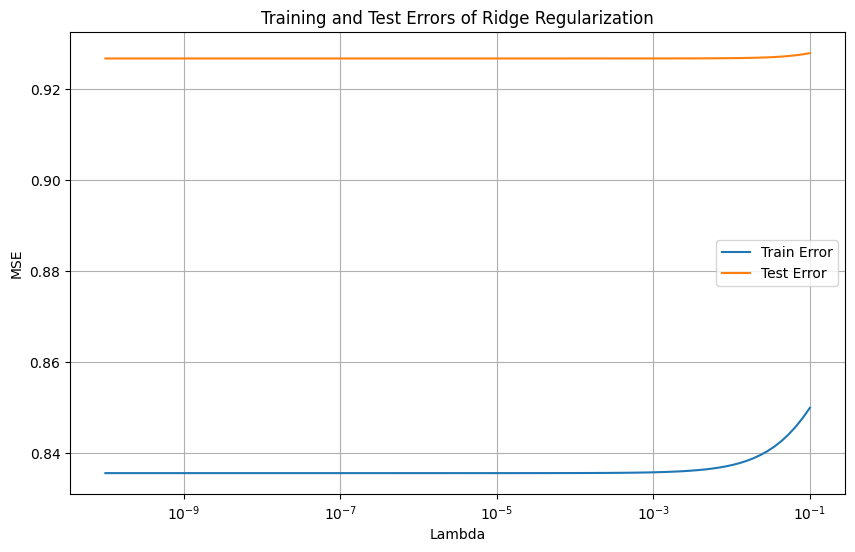

In [28]:
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
train_errors = []
test_errors =[]

for alpha in alphas:
    # create pipeline: fit poly to build feature matrix -> SGD
    sgd = SGDLinearRegressor(batch_size=1,
                       eta=0.01, tau_max=1000, epsilon=1e-5, 
                       alpha=alpha, random_state=0)
    model = make_pipeline(poly, sgd)

    # fit and predit y_pred and cal train_error
    model.fit(x_train_tran, y_train)
    y_train_pred = model.predict(x_train_tran)
    train_errors.append(np.mean((y_train_pred - y_train) ** 2))
    
    y_test_pred = model.predict(x_test_tran)
    test_errors.append(np.mean((y_test_pred - y_test)**2))
    
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_errors, label='Train Error')
plt.plot(alphas, test_errors, label='Test Error')
plt.xscale('log') 

plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('Training and Test Errors of Ridge Regularization')
plt.legend()
plt.grid(True)
plt.show()

Mean square error is small and stable for both train and test error when lambda is within the range of 10^-9 and 10^-3. In the case of overfitting, train error will drop to 0 while test error start increasing. Therefore we can confirm the model is not overfitting within 10^-9 and 10^-3.   

As lambda increase and reach 10^-1, both test and train erro increase. This indicates the model start to become underfitted as the model is penealised too much and become too simple to catch the pattern.  

This aligns with the fact that, as the penalised term (regularization) increase, the model is punished for being over-complicated and hence the model will become simpler. If the parameter is large enough, the model will be underfit.

#### b

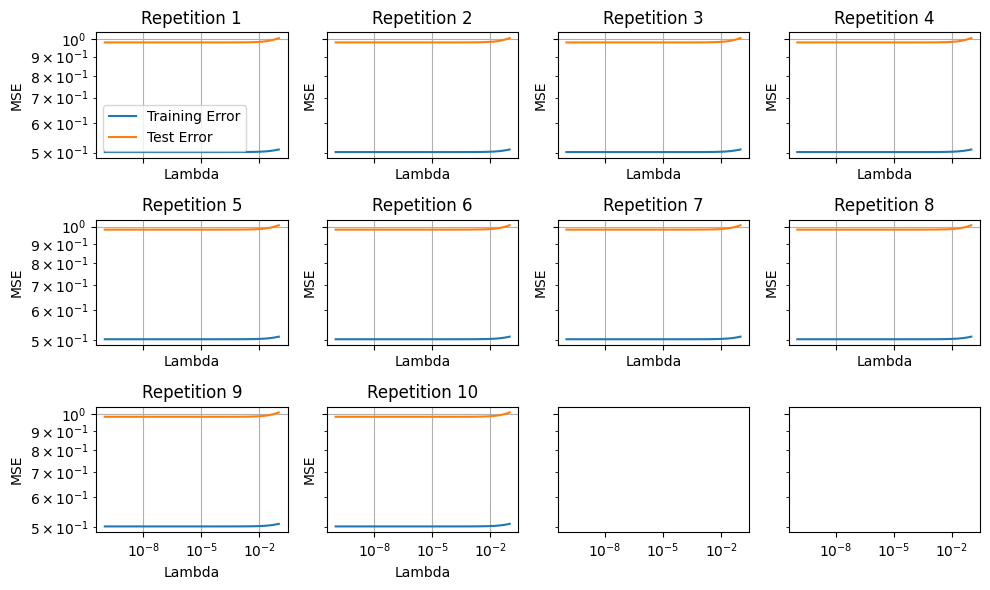

In [32]:
train_errors_avg = []
test_errors_avg = []

reps = 10
_, axs = plt.subplots(3, 4, tight_layout=True, 
                      sharex=True, sharey=True,
                      figsize=(10, 6 ))


for i in range(reps):
    train_errors = []
    test_errors = []

    for alpha in alphas:
            # create pipeline: fit poly to build feature matrix -> SGD
            sgd = SGDLinearRegressor(batch_size=1,
                               eta=0.01, tau_max=1000, epsilon=1e-5, 
                               alpha=alpha, random_state=0)
            model = make_pipeline(poly, sgd)
    
            # new training set for each rep
            x_train_sample, y_train_sample = make_additive_noise_data(20, f, -0.3, 0.3, random_state=42)
    
            model.fit(poly.transform(x_train_sample), y_train_sample)
            y_train_pred = model.predict(poly.transform(x_train_sample))
            train_errors.append(np.mean((y_train_pred - y_train_sample) ** 2))
    
            x_test, y_test = make_additive_noise_data(20, f, -0.3, 0.3, random_state=0)
            x_test_tran = poly.transform(x_test)
            y_test_pred = model.predict(x_test_tran)
            test_errors.append(np.mean((y_test_pred - y_test)**2))
    
    train_errors_avg.append(train_errors)
    test_errors_avg.append(test_errors)

    row = i // 4
    col = i % 4
    axs[row, col].plot(alphas, train_errors, label='Training Error')
    axs[row, col].plot(alphas, test_errors, label='Test Error')
    axs[row, col].set_xlabel('Lambda')
    axs[row, col].set_xscale('log')
    axs[row, col].set_yscale('log')
    axs[row, col].set_ylabel('MSE')
    axs[row, col].set_title(f'Repetition {i+1}')
    axs[0, 0].legend()
    axs[row, col].grid(True)
plt.show()

### c

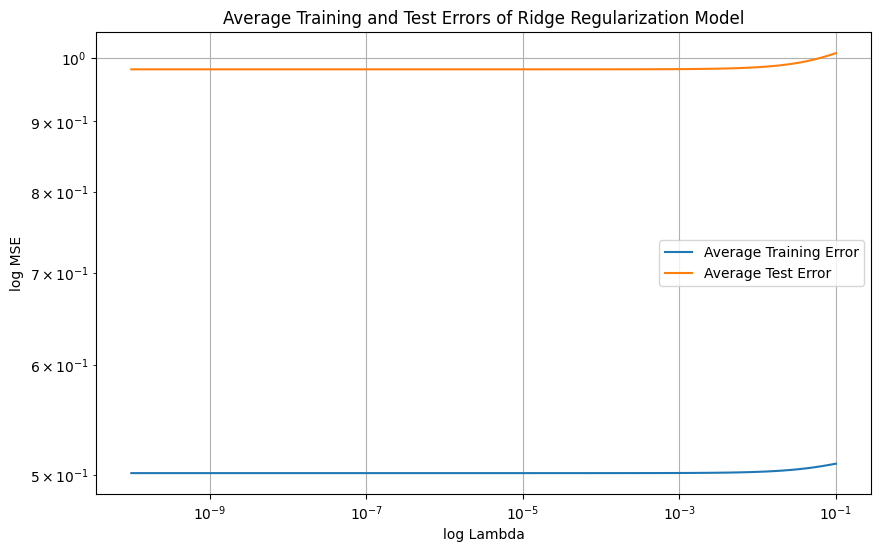

In [33]:
train_errors_avg = np.array(train_errors_avg)
test_errors_avg = np.array(test_errors_avg)

avg_train_errors = np.mean(train_errors_avg, axis=0)
avg_test_errors = np.mean(test_errors_avg, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(alphas, avg_train_errors, label='Average Training Error')
plt.plot(alphas, avg_test_errors, label='Average Test Error')
plt.xlabel('log Lambda')
plt.ylabel('log MSE')
plt.title('Average Training and Test Errors of Ridge Regularization Model')
plt.legend()
plt.xscale('log')  
plt.yscale('log')  
plt.grid(True)
plt.show()


From the average error rate, similar result of above can be concluded.  

MSE is low and seems to be constant when log(lambda) wihtin 10^-9 and 10^-1. In the case of overfitting, training error will drop to 0 while test error start increasing. Therefore we can confirm the model is not overfitting within 10^-9 and 10^-3. In this range, the model complexity is acceptably complex to capture the pattern, yet not to complex to explain the result.

As lambda increases and reach 10^-1, both test and train error increase. This indicates the model start to become underfitted as the model is penealised too much and become too simple to catch the pattern. Hence causing both error rate to increase. In this range, the model is considered to be too simple.

This aligns with the fact that, as the penalised term (regularization) increase, the model is punished for being over-complicated and hence the model will become simpler. If the parameter is large enough, the model will be underfit.

